## Business Problem

Businesses lack reliable tools to understand and predict macroeconomic shifts, particularly concerning unemployment and inflation, leading to suboptimal planning. This project analyzes 80+ years of data to develop insights for improved business cycle management.

## Conclusion

Our analysis of long-term macroeconomic data has revealed statistically significant patterns in business cycle lengths, providing insights into the dynamics of economic transitions. Based on these patterns, our model predicts a 29% probability of a shift from stable growth to slow growth or recession within the next 12 months, starting in Q1 2025. This prediction aligns with the consensus view of many economists, as evidenced by Bankrate's 2024 Q4 Economic Indicator Survey. This convergence of our findings with expert opinion reinforces the need for businesses to proactively prepare for potential economic headwinds.

## Outline of Notebook
1. Exploratory Data Analysis and Data Visualization
2. Machine Learning Modeling (K-Means Clustering) to build macroeconomic clusters
3. Statistical Hypothesis Testing for the lengths of business cycles
4. Business Recommendation


## Exploratory Data Analysis and Data Visualization

In [1]:
import pandas as pd
import pandas_datareader as pdr
import datetime 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
import statsmodels as sm
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter(action="ignore")

In [2]:
# Gather Inflation and Unemployment Rate data

CPI_df = pd.read_excel (r'/home/elaineqiao/data/Step1/CPI_USA.xls') 
Unemployment_df = pd.read_excel (r'/home/elaineqiao/data/Step1/Unemployment_USA.xls') 

In [3]:
# Normalize the data

Inflation_Unemploymt_df = pd.merge(CPI_df, Unemployment_df, on='observation_date')

Inflation_Unemploymt_df['Unemployment Rate Normalized'] = (Inflation_Unemploymt_df['Unemployment Rate'] -Inflation_Unemploymt_df['Unemployment Rate'].min())/(Inflation_Unemploymt_df['Unemployment Rate'].max() -Inflation_Unemploymt_df['Unemployment Rate'].min())

Inflation_Unemploymt_df['Monthly Inflation Rate'] = ((Inflation_Unemploymt_df['CPI']/ Inflation_Unemploymt_df['CPI'].shift(1)) -1)*100
Inflation_Unemploymt_df['Annual Inflation Rate'] = ((Inflation_Unemploymt_df['CPI']/ Inflation_Unemploymt_df['CPI'].shift(12)) -1)*100

Inflation_Unemploymt_df['Annual Inflation Rate Normalized'] = (Inflation_Unemploymt_df['Annual Inflation Rate'] -Inflation_Unemploymt_df['Annual Inflation Rate'].min())/(Inflation_Unemploymt_df['Annual Inflation Rate'].max() -Inflation_Unemploymt_df['Annual Inflation Rate'].min())

Inflation_Unemploymt_df.dropna().head()

,observation_date,CPI,Unemployment Rate,Unemployment Rate Normalized,Monthly Inflation Rate,Annual Inflation Rate,Annual Inflation Rate Normalized
12,1949-01-01,24.01,4.3,0.146341,-0.166320,1.393581,0.249238
13,1949-02-01,23.91,4.7,0.178862,-0.416493,1.013942,0.227644
14,1949-03-01,23.91,5.0,0.203252,0.000000,1.744681,0.269209
15,1949-04-01,23.92,5.3,0.227642,0.041824,0.419815,0.193849
16,1949-05-01,23.91,6.1,0.292683,-0.041806,-0.416493,0.146279


<Axes: xlabel='Unemployment Rate', ylabel='Annual Inflation Rate'>

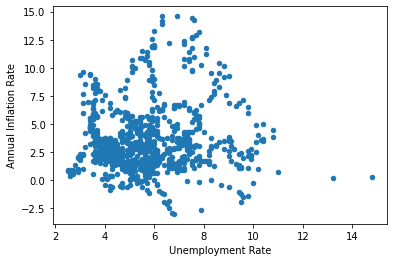

In [4]:
# Create scatter plots for inflation and unemployment rates from 1949 to Jan 2025

Inflation_Unemploymt_df.plot.scatter(x='Unemployment Rate', y='Annual Inflation Rate')

<Axes: xlabel='observation_date', ylabel='Unemployment Rate'>

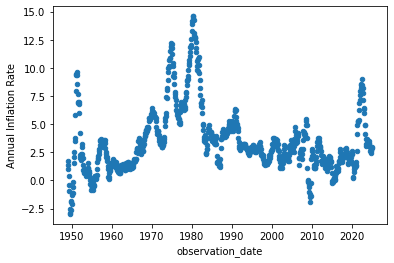

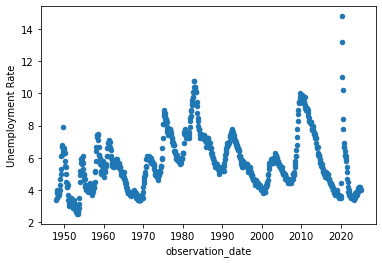

In [5]:
# Create plots of observation_date vs annual inflation rate or unemployment rate

Inflation_Unemploymt_df.plot.scatter(x='observation_date', y='Annual Inflation Rate')
Inflation_Unemploymt_df.plot.scatter(x='observation_date', y='Unemployment Rate')

## Machine Learning Modeling (K-Means Clustering) to build macroeconomic clusters

In [6]:
# Apply K-Means clustering

Inflation_Unemploymt_df2 = Inflation_Unemploymt_df.dropna()
Inf_Unem = Inflation_Unemploymt_df2[['Unemployment Rate Normalized', 'Annual Inflation Rate Normalized']].to_numpy()
num = 3

km = KMeans(n_clusters=num, random_state=0, n_init='auto').fit(Inf_Unem)
l_km = km.labels_
c_km = km.cluster_centers_

Text(0, 0.5, 'Annual Inflation Rate Normalized')

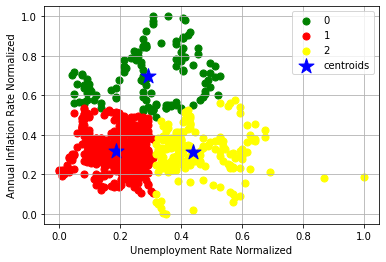

In [7]:
# Plot different macroeconomic clusters with normalized data

color_list = ['green', 'red', 'yellow', 'purple', 'pink', 'orange', 'cyan', 'lightgreen', 'olive']

plt.figure()

for i in range(num):
    plt.scatter(Inf_Unem[l_km == i, 0], Inf_Unem[l_km == i, 1], s = 50, c = color_list[i], label = i)
    
# Plot all the centroids
plt.scatter(c_km[:, 0], c_km[:, 1], s = 250, c = 'blue', marker = '*', label = 'centroids')

plt.legend(scatterpoints = 1)
plt.grid()
plt.xlabel('Unemployment Rate Normalized')
plt.ylabel('Annual Inflation Rate Normalized')


Text(0, 0.5, 'Annual Inflation Rate')

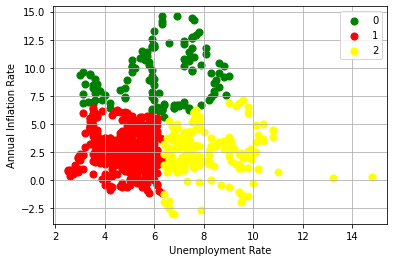

In [8]:
# Add a cluster label column to the orginal dataframe 
Inflation_Unemploymt_df2.loc[:, 'cluster'] = l_km


# Plot different macroeconomic clusters with original data

plt.figure()

for i in range(num):
    subset_df = Inflation_Unemploymt_df2.loc[Inflation_Unemploymt_df2['cluster'] == i]
    plt.scatter(
        subset_df['Unemployment Rate'],
        subset_df['Annual Inflation Rate'],
        s=50,
        c=color_list[i],
        label=i,
    )
    
plt.legend(scatterpoints = 1)
plt.grid()
plt.xlabel('Unemployment Rate')
plt.ylabel('Annual Inflation Rate')

In [9]:
# Create a list of dataframes corresponding to all the clusters
cluster_list = []

for i in range(num):
    cluster_df = Inflation_Unemploymt_df2.loc[Inflation_Unemploymt_df2['cluster'] == i]
    cluster_list.append(cluster_df)
    timedf = cluster_df['observation_date']
    # plt.figure()
    # timedf.groupby([timedf.dt.year]).count().plot(kind="bar", label = i)
    # plt.legend()
    
# Create a list of dates when there is a transition from one cluster to another     

change_cluster_dates = []
Inflation_Unemploymt_df2.loc[:, 'cluster change'] = Inflation_Unemploymt_df2.loc[:, 'cluster'] - Inflation_Unemploymt_df2.loc[:, 'cluster'].shift(1)
Inflation_Unemploymt_df2 = Inflation_Unemploymt_df2.iloc[1:] #removes the first row.


for index, row in Inflation_Unemploymt_df2[1:].iterrows():
    if row['cluster change'] != 0:
        change_cluster_dates.append([index, row['observation_date']])

# Create a list of continuous time intervals within individual clusters

cluster_time_intervals_months = []
cluster_time_intervals_days = []

for i in range(1, len(change_cluster_dates)):
    diff = (change_cluster_dates[i][1] - change_cluster_dates[i - 1][1]).days
    cluster_time_intervals_days.append(diff)
    cluster_time_intervals_months.append(change_cluster_dates[i][0] - change_cluster_dates[i - 1][0])
    
# plt.figure()
# plt.hist(cluster_time_intervals_months, bins=10, label = 'Cluster Time Intervals No. of Months')
# plt.legend()


The length of a business cycle here is defined to be the length of continuous time interval between two consecutive changes of macroeconomic clusters. 

Hypothesis: The lengths of business cycles follow a geometric and an exponential distribution.  


In [17]:
min_month_change = min(cluster_time_intervals_months)
max_month_change = max(cluster_time_intervals_months)
mean_month_change = np.mean(cluster_time_intervals_months)

# Get an exponential random variable and a geometric random variable with the same parameters

# exponential distribution
rv = scipy.stats.expon(min_month_change, mean_month_change)

# geometric distribution
rv2 = scipy.stats.geom(1/mean_month_change)

# chisqure test for categorical data (exponential and geometric distributions)
# bins = plt.hist(cluster_time_intervals_months, bins=10)[1]
# observations = plt.hist(cluster_time_intervals_months, bins=10)[0]
ob = np.asarray(observations)

expectations1 = []
expectations2 = []

for i in range(1, len(bins) - 1):
    expectation1 = (rv.cdf(bins[i]) - rv.cdf(bins[i - 1]))*len(cluster_time_intervals_months)
    expectations1.append(expectation1)
    expectation2 = (rv2.cdf(bins[i]) - rv2.cdf(bins[i - 1]))*len(cluster_time_intervals_months)
    expectations2.append(expectation2)
last1 = len(cluster_time_intervals_months) - sum(expectations1)
last2 = len(cluster_time_intervals_months) - sum(expectations2)
expectations1.append(last1)
expectations2.append(last2)
    
ex1 = np.asarray(expectations1)
ex2 = np.asarray(expectations2)

chisq1, p1 = scipy.stats.chisquare(ob, ex1)
print("The p-value for the hpothesis test regarding exponential distribution is " + str(p1))

chisq2, p2 = scipy.stats.chisquare(ob, ex2)
print("The p-value for the hpothesis test regarding geometric distribution is " + str(p2))

print('The average lengths of business cycles is ' + str(mean_month_change) + ' '+ 'months')
print('The probability of major economic shifts during the following month is ' + str(1/mean_month_change))


The p-value for the hpothesis test regarding exponential distribution is 0.6344007703384207
The p-value for the hpothesis test regarding geometric distribution is 0.7861526807918913
The average lengths of business cycles is 35.24 months
The probability of major economic shifts during the following month is 0.028376844494892167


## Modeling Conclusion

Conclusion of the hypothesis testing: since the p-values p1 and p2 above are much larger than the standard 0.05 cutoff, we do not reject our hypotheses. 

Overall modeling conclusion: the lengths of business cycles follow a geometric distribution with mean 35.24 months, and the probability of changing business cycle/macroeconomic cluster during the next month is 1/35.24 = 0.028376844494892167. 

In [19]:
# Compute the probability of switching from stable growths to slow growths/recession 
# during the next 12 months starting Q1 2025.

print('The probability of major economic shifts during the next 12 months is ' + str(1 - (1 - 1/mean_month_change)**12))

The probability of major economic shifts during the next 12 months is 0.29209614854011867


## Business Conclusion and Recommendation

Our analysis of long-term macroeconomic data has revealed statistically significant patterns in business cycle lengths, providing insights into the dynamics of economic transitions. Based on these patterns, our model predicts a 29.2% probability of a shift from stable growth to slow growth or recession within the next 12 months, starting in Q1 2025. This prediction aligns with the consensus view of many economists, as evidenced by Bankrate's Q4 Economic Indicator Survey. This convergence of our findings with expert opinion reinforces the need for businesses to proactively prepare for potential economic headwinds.

## Business Recommendations

Given the substantial probability of an economic downturn, we strongly recommend that businesses implement the following strategies:

1. Strengthen Financial Resilience: Conduct rigorous stress testing of financial models, optimize cash flow, and build up reserves to weather potential revenue declines.
2. Refine Sales and Marketing Strategies: Focus on customer retention, explore revenue diversification, and implement targeted marketing campaigns to maintain market share.
3. Enhance Operational Efficiency: Review and optimize supply chains, streamline processes, and implement strict cost controls to improve profitability during a slowdown.
4. Implement Contingency Planning: Develop detailed contingency plans for various recessionary scenarios, including workforce adjustments and expense reduction strategies.
5. Proactive Communication: Maintain open and transparent communication with stakeholders, including employees, customers, and investors, to build confidence and manage expectations.